In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import pchip_interpolate

from genetic_algorithm_pfm.genetic_algorithm_pfm.algorithm import GeneticAlgorithm

Set Weights for Different Objectives

In [4]:
def objective_p1(X):
    """
    Minimised costs: O1 - Government
    """
    L = X[:, 0]
    B = X[:, 1] 
    H = X[:, 2]
    N = X[:, 3]
    c1 = 20000
    c2 = 13000
    c3 = 560000

    F1 = c1 * (2*L * (2 * H + B)) + c2 * 0.4 *  H * B + c3 * N
    p_value = pchip_interpolate([3e8,1.8e9 ,3e9 ], [100,65,0], F1)
    return p_value 


def objective_p2(X):
    """
    Maximised capacity: O2 - Vessels (aantal schepen per dag)
    """
    L = X[:, 0]
    B = X[:, 1]
    H = X[:, 2]
    N = X[:, 3]

    c4 = 0.8
    Aship = 9691.5
    c5 = 0.4
    c6 =  2.3148e-4
    vvaar = 168000
    F2 = (L*B*c4)/(Aship * ((L/(vvaar*c5)+N*c6)))
    p_value = pchip_interpolate([100,300,500], [0, 50, 100], F2)
    return p_value

def objective_p3(X):
    """
    Maximum water elevation retaining height: O3 - Safety experts
    """
    L = X[:, 0]
    B = X[:, 1]
    H = X[:, 2]
    N = X[:, 3]

    c7 = 1
    F3 = c7 * H
    p_value = pchip_interpolate([0,10,25], [0,40,100], F3)
    return p_value

def objective_p4(X):
    """
    Minimized environmental effects: O4 - Local residents
    """
    L = X[:, 0]
    B = X[:, 1]
    H = X[:, 2]
    N = X[:, 3]

    c8 = 35
    c9 = 210
    c10 = 105

    F4 =  c8 * (2*L * (2 * H + B))  + c9 * 0.4 * H * B+ c10 * N
    p_value = pchip_interpolate([6e5,3e6,6e6], [100,50,0], F4)
    return p_value

def objective_p5(X):
    """
    Maximized car transport over lock - Municipality 
    """
    L = X[:, 0]
    B = X[:, 1]
    H = X[:, 2]
    N = X[:, 3]

    c11 = 100

    F5 =  c11 * N
    p_value = pchip_interpolate([0,400,800], [0,65,100], F5)
    return p_value

def objective(X):
    """
    Objective function that is fed to the GA. Calles the separate preference functions that are declared above.

    :param variables: array with design variable values per member of the population. Can be split by using array
    slicing
    :return: 1D-array with aggregated preference scores for the members of the population.
    """
    # extract 1D design variable arrays from full 'variables' array

    # calculate the preference scores
    p_1 = objective_p1(X)
    p_2 = objective_p2(X)
    p_3 = objective_p3(X)
    p_4 = objective_p4(X)
    p_5 = objective_p5(X)

    w1 = 0.2
    w2 = 0.2
    w3 = 0.2
    w4 = 0.2
    w5 = 0.2
    
    return [w1, w2, w3, w4, w5], [p_1, p_2, p_3, p_4, p_5]

Define Constraints and Bounds


In [5]:
b1 = [270, 550]  # L
b2 = [30, 90]  # B
b3 = [0,25] # H
b4 = [0,8] # N

bounds = [b1, b2, b3, b4]

def constraint_1(X):
    """Maximum costs: 1,7 miljard"""
    L = X[:, 0]
    B = X[:, 1]
    H = X[:, 2]
    N = X[:, 3]
    c1 = 20000
    c2 = 13000
    c3 = 560000
    return c1 * (2 * L * (2 * H + B)) + c2 * 0.4 * H * B + c3 * N - 1.7e9  # < 0

def constraint_2(X):
    """Minimum number of vessels/day: 60"""
    L = X[:, 0]
    B = X[:, 1]
    H = X[:, 2]
    N = X[:, 3]
    c4 = 0.8
    Aship = 9691.5
    c5 = 0.4
    c6 = 2.3148e-4
    vvaar = 168000
    vessels_per_day = (L * B * c4) / (Aship * ((L / (vvaar * c5) + N * c6)))
    return -(vessels_per_day) + 60  # < 0

def constraint_3(X):
    """Minimum water capacity: 15.5 m"""
    H = X[:, 2]
    return -(H) + 15.5  # < 0

def constraint_4(X):
    """Maximum emissions: 3*10^5 ton CO2"""
    L = X[:, 0]
    B = X[:, 1]
    H = X[:, 2]
    N = X[:, 3]
    c8 = 35
    c9 = 210
    c10 = 105
    emissions = c8 * (2 * L * (2 * H + B)) + c9 * 0.4 * H * B + c10 * N
    return emissions - 3e5  # < 0

def constraint_5(X):
    """Minimum number of cars crossing/hour: 100"""
    N = X[:, 3]
    cars_per_hour = 100 * N
    return -(cars_per_hour) + 100  # < 0


cons = [['ineq', constraint_1], ['ineq', constraint_2], ['ineq', constraint_3], ['ineq', constraint_4], ['ineq', constraint_5]]


Graphical Output


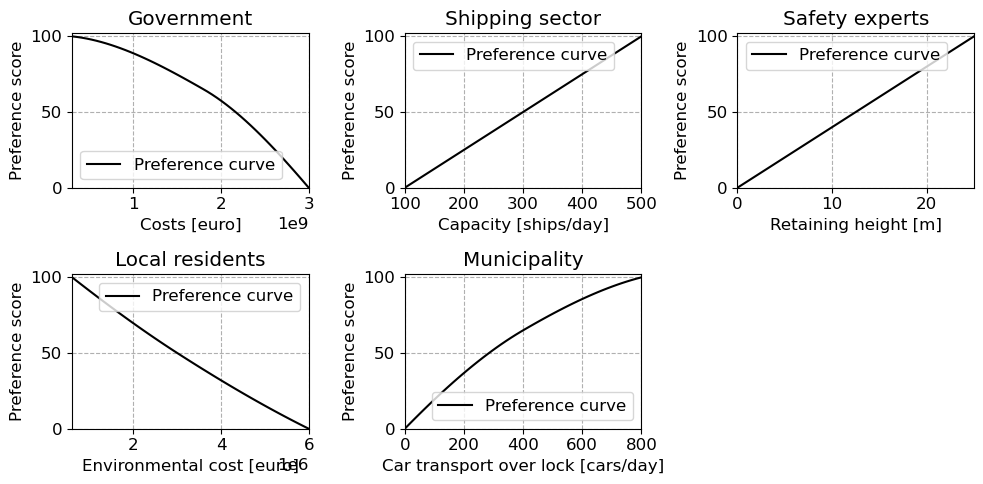

In [6]:
# create arrays for plotting continuous preference curves
c1 = np.linspace(3e8, 3e9)
c2 = np.linspace(100, 500)
c3 = np.linspace(0, 25)
c4 = np.linspace(6e5, 6e6)
c5 = np.linspace(0, 800)

# calculate the preference functions
p1 = pchip_interpolate([3e8,1.8e9 ,3e9 ], [100,65,0], (c1))
p2 = pchip_interpolate([100,300,500], [0, 50, 100], (c2))
p3 = pchip_interpolate([0,10,25], [0,40,100], (c3))
p4 = pchip_interpolate([6e5,3e6,6e6], [100,50,0], (c4))
p5 = pchip_interpolate([0,400,800], [0,65,100], (c5))


# create figure that plots all preference curves and the preference scores of the returned results of the GA
fig = plt.figure(figsize=((10,5)))

font1 = {'size':20}
font2 = {'size':15}

plt.rcParams['font.size'] = '12'
plt.rcParams['savefig.dpi'] = 300

ax1 = fig.add_subplot(2, 3, 1)
ax1.plot(c1, p1, label='Preference curve', color='black')
ax1.set_xlim((3e8, 3e9))
ax1.set_ylim((0, 102))
ax1.set_title('Government')
ax1.set_xlabel('Costs [euro]')
ax1.set_ylabel('Preference score')
ax1.grid()
ax1.grid(linestyle = '--')

#fig = plt.figure()
ax2 = fig.add_subplot(2, 3, 2)
ax2.plot(c2, p2, label='Preference curve', color='black')
ax2.set_xlim((100, 500))
ax2.set_ylim((0, 102))
ax2.set_title('Shipping sector')
ax2.set_xlabel('Capacity [ships/day]')
ax2.set_ylabel('Preference score')
ax2.grid()
ax2.legend()
ax2.grid(linestyle = '--')

ax3 = fig.add_subplot(2, 3, 3)
ax3.plot(c3, p3, label='Preference curve', color='black')
ax3.set_xlim((0, 25))
ax3.set_ylim((0, 102))
ax3.set_title('Safety experts')
ax3.set_xlabel('Retaining height [m]')
ax3.set_ylabel('Preference score')
ax3.grid()
ax3.grid(linestyle = '--')

ax4 = fig.add_subplot(2, 3, 4)
ax4.plot(c4, p4, label='Preference curve', color='black')
ax4.set_xlim((6e5, 6e6))
ax4.set_ylim((0, 102))
ax4.set_title('Local residents')
ax4.set_xlabel('Environmental cost [euro]')
ax4.set_ylabel('Preference score')
ax4.grid()
ax4.grid(linestyle = '--')

ax5 = fig.add_subplot(2, 3, 5)
ax5.plot(c5, p5, label='Preference curve', color='black')
ax5.set_xlim((0, 800))
ax5.set_ylim((0, 102))
ax5.set_title('Municipality')
ax5.set_xlabel('Car transport over lock [cars/day]')
ax5.set_ylabel('Preference score')
ax5.grid()
ax5.grid(linestyle = '--')


ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
ax5.legend()
fig.tight_layout()
plt.show()

#Two  lines to make our compiler able to draw:
#fig.savefig("/home/ruud/engineeringdesign.education/static/urbanplanningproblemfunctions.png")

Optimization

Now we have everything for the optimization, we can run it. For more information about the different options to configure the GA, see the docstring of GeneticAlgorithm (via help()) or chapter 4 of the reader. Once we have the results, we can make some figures. First, the resulting design variables are plotted into the solution space. Secondly, we can plot the preference functions together with the results of the optimizations.



Run GA with minmax
The type of aggregation is set to minmax
Generation   Best score   Mean             Max stall    Diversity    Number of non-feasible results
0            200000000.0  383600000.0      0            0.004        500         
1            200000000.0  230800000.0      1            0.008        500         
2            200000000.0  221200000.0      2            0.008        500         
3            200000000.0  218400000.0      3            0.01         500         
4            200000000.0  214800000.0      4            0.01         500         
5            200000000.0  218000000.0      5            0.01         500         
6            200000000.0  210000000.0      6            0.008        500         
7            200000000.0  218800000.0      7            0.009        500         
8            200000000.0  215600000.0      8            0.012        500         
Stopped at gen 8
The number of generations is terribly close to the number of max stall iterations. Th

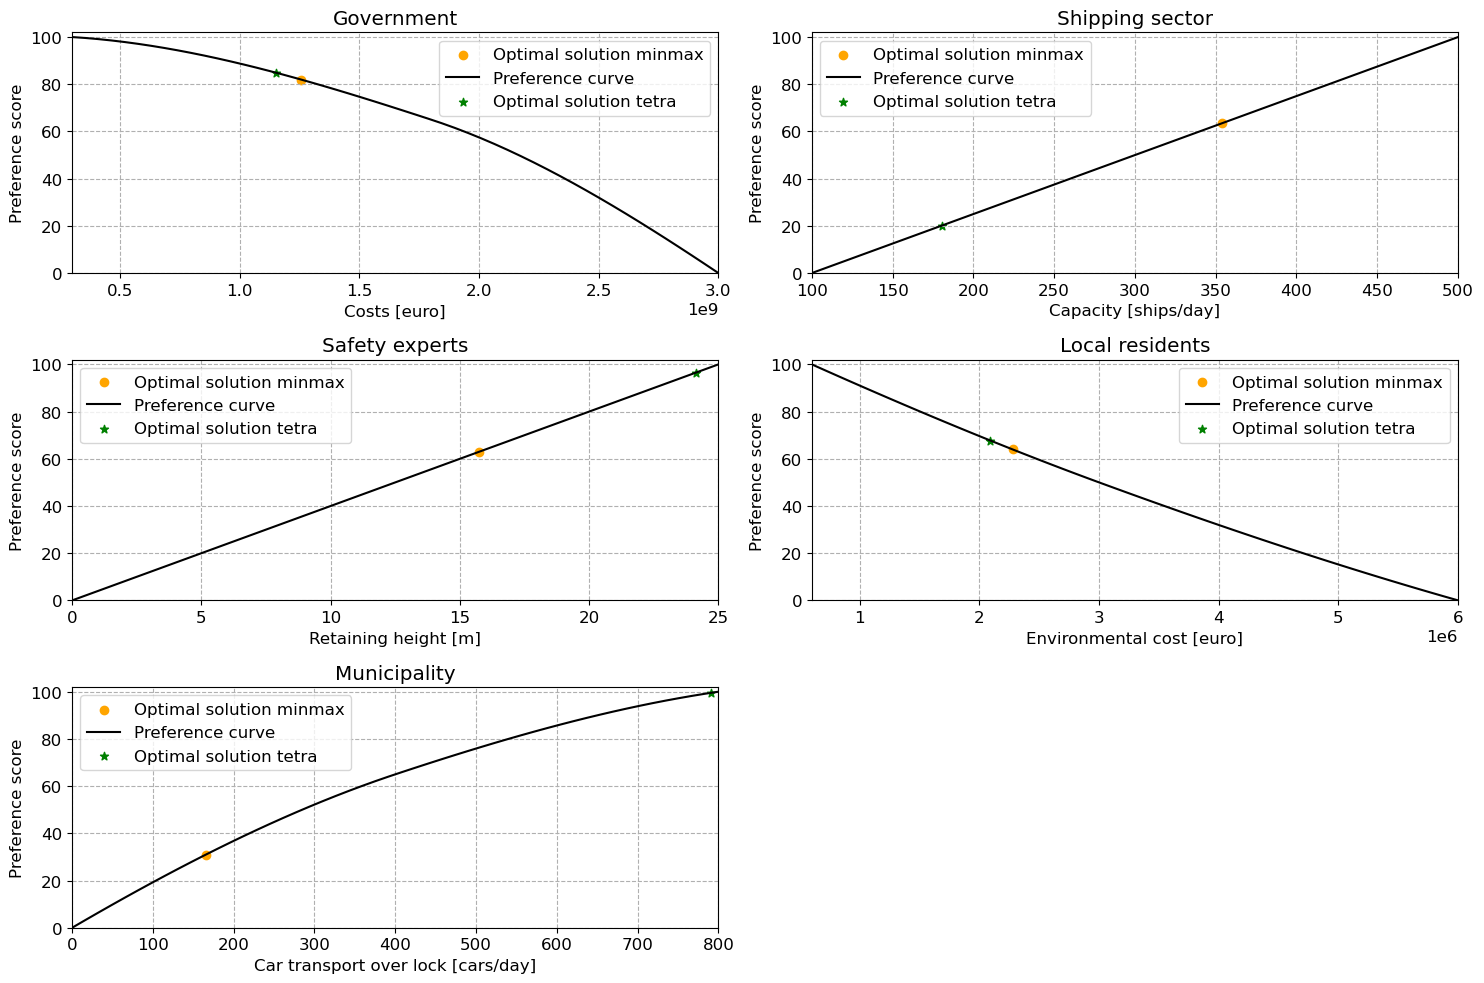

In [8]:
# We run the optimization with two paradigms
paradigm = ['minmax', 'tetra']
marker = ['o', '*']
colours = ['orange','green']

fig = plt.figure(figsize=(15, 10))

ax1 = fig.add_subplot(3, 2, 1)
ax2 = fig.add_subplot(3, 2, 2)
ax3 = fig.add_subplot(3, 2, 3)
ax4 = fig.add_subplot(3, 2, 4)
ax5 = fig.add_subplot(3, 2, 5)

for i in range(2):
    # make dictionary with parameter settings for the GA run with the IMAP solver
    options = {
        'n_bits': 8,
        'n_iter': 400,
        'n_pop': 500,
        'r_cross': 0.8,
        'max_stall': 8,
        'aggregation': paradigm[i], # minmax or tetra
        'var_type': 'real' 
    }
    
    print(f'Run GA with ' + paradigm[i])
    ga = GeneticAlgorithm(objective=objective, constraints=cons, bounds=bounds, options=options)
    score_IMAP, design_variables_IMAP, _ = ga.run()
    
    # Calculate individual preference scores for the GA results
    # Ensure design_variables_IMAP has 4 elements
    L = design_variables_IMAP[0]
    B = design_variables_IMAP[1]
    H = design_variables_IMAP[2]
    N = design_variables_IMAP[3]
        # O1 - Government
    F1 = 20000 * (2 * L * (2 * H + B)) + 13000 * 0.4 * H * B + 560000 * N
    p1_res = pchip_interpolate([3e8, 1.8e9, 3e9], [100, 65, 0], F1)
        # O2 - Shipping sector
    F2 = (L * B * 0.8) / (9691.5 * ((L / (168000 * 0.4) + N * 2.3148e-4)))
    p2_res = pchip_interpolate([100,300,500], [0, 50, 100], F2)
        # O3 - Safety experts
    F3 = H
    p3_res = pchip_interpolate([0, 10, 25], [0, 40, 100], F3)
        # O4 - Local residents
    F4 = 35 * (2 * L * (2 * H + B)) + 210 * 0.4 * H * B + 105 * N
    p4_res = pchip_interpolate([6e5, 3e6, 6e6], [100, 50, 0], F4)
        # O5 - Municipality
    F5 = 100 * N
    p5_res = pchip_interpolate([0, 400, 800], [0, 65, 100], F5)

        # Scatter the results on the preference curve plots
    ax1.scatter(F1, p1_res, label='Optimal solution ' + paradigm[i], color=colours[i], marker=marker[i])
    ax2.scatter(F2, p2_res, label='Optimal solution ' + paradigm[i], color=colours[i], marker=marker[i])
    ax3.scatter(F3, p3_res, label='Optimal solution ' + paradigm[i], color=colours[i], marker=marker[i])
    ax4.scatter(F4, p4_res, label='Optimal solution ' + paradigm[i], color=colours[i], marker=marker[i])
    ax5.scatter(F5, p5_res, label='Optimal solution ' + paradigm[i], color=colours[i], marker=marker[i])

    print(L,B,H,N)
    # Plot the preference curves for all 5 objectives (only once)
    if i == 0:
        # Government
        c1 = np.linspace(3e8, 3e9)
        p1 = pchip_interpolate([3e8, 1.8e9, 3e9], [100, 65, 0], c1)
        ax1.plot(c1, p1, label='Preference curve', color='black')
        ax1.set_xlim((3e8, 3e9))
        ax1.set_ylim((0, 102))
        ax1.set_title('Government')
        ax1.set_xlabel('Costs [euro]')
        ax1.set_ylabel('Preference score')
        ax1.grid()
        ax1.grid(linestyle='--')

        # Shipping sector
        c2 = np.linspace(100, 500)
        p2 = pchip_interpolate([100,300,500], [0, 50, 100], c2)
        ax2.plot(c2, p2, label='Preference curve', color='black')
        ax2.set_xlim((100, 500))
        ax2.set_ylim((0, 102))
        ax2.set_title('Shipping sector')
        ax2.set_xlabel('Capacity [ships/day]')
        ax2.set_ylabel('Preference score')
        ax2.grid()
        ax2.legend()
        ax2.grid(linestyle='--')

        # Safety experts
        c3 = np.linspace(0, 25)
        p3 = pchip_interpolate([0, 10, 25], [0, 40, 100], c3)
        ax3.plot(c3, p3, label='Preference curve', color='black')
        ax3.set_xlim((0, 25))
        ax3.set_ylim((0, 102))
        ax3.set_title('Safety experts')
        ax3.set_xlabel('Retaining height [m]')
        ax3.set_ylabel('Preference score')
        ax3.grid()
        ax3.grid(linestyle='--')

        # Local residents
        c4 = np.linspace(6e5, 6e6)
        p4 = pchip_interpolate([6e5, 3e6, 6e6], [100, 50, 0], c4)
        ax4.plot(c4, p4, label='Preference curve', color='black')
        ax4.set_xlim((6e5, 6e6))
        ax4.set_ylim((0, 102))
        ax4.set_title('Local residents')
        ax4.set_xlabel('Environmental cost [euro]')
        ax4.set_ylabel('Preference score')
        ax4.grid()
        ax4.grid(linestyle='--')

        # Municipality
        c5 = np.linspace(0, 800)
        p5 = pchip_interpolate([0, 400, 800], [0, 65, 100], c5)
        ax5.plot(c5, p5, label='Preference curve', color='black')
        ax5.set_xlim((0, 800))
        ax5.set_ylim((0, 102))
        ax5.set_title('Municipality')
        ax5.set_xlabel('Car transport over lock [cars/day]')
        ax5.set_ylabel('Preference score')
        ax5.grid()
        ax5.grid(linestyle='--')
# Add legends and adjust layout after plotting all data points
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
ax5.legend()
fig.tight_layout()
plt.show()



In [1]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import pchip_interpolate

# === Sliders voor de 5 gewichten ===
w1 = widgets.FloatSlider(description='Government', min=0, max=1, step=0.05, value=0.2)
w2 = widgets.FloatSlider(description='Shipping', min=0, max=1, step=0.05, value=0.2)
w3 = widgets.FloatSlider(description='Safety', min=0, max=1, step=0.05, value=0.2)
w4 = widgets.FloatSlider(description='Residents', min=0, max=1, step=0.05, value=0.2)
w5 = widgets.FloatSlider(description='Municipality', min=0, max=1, step=0.05, value=0.2)

run_button = widgets.Button(description='🚀 Run both optimizations', button_style='success')
out = widgets.Output()

def on_run_clicked(b):
    with out:
        clear_output(wait=True)
        print("Running both Genetic Algorithm paradigms (minmax & tetra)... ⏳")

        # Normaliseer gewichten
        weights = np.array([w1.value, w2.value, w3.value, w4.value, w5.value])
        weights = weights / np.sum(weights)

        def objective_weighted(X):
            p_values = [
                objective_p1(X),
                objective_p2(X),
                objective_p3(X),
                objective_p4(X),
                objective_p5(X),
            ]
            return weights, p_values

        paradigms = ['minmax', 'tetra']
        colours = ['orange', 'green']
        markers = ['o', '*']
        results = {}

        # Plot setup
        fig, axes = plt.subplots(3, 2, figsize=(15, 10))
        axes = axes.flatten()
        titles = ['Government', 'Shipping sector', 'Safety experts', 'Local residents', 'Municipality']
        x_labels = ['Costs [euro]', 'Capacity [ships/day]', 'Retaining height [m]', 'Environmental cost [euro]', 'Car transport [cars/day]']
        pref_curves = [
            ([3e8, 1.8e9, 3e9], [100, 65, 0]),
            ([100, 300, 500], [0, 50, 100]),
            ([0, 10, 25], [0, 40, 100]),
            ([6e5, 3e6, 6e6], [100, 50, 0]),
            ([0, 400, 800], [0, 65, 100]),
        ]

        for agg, color, marker in zip(paradigms, colours, markers):
            print(f"\n▶️ Running GA with aggregation = '{agg}'")
            options = {
                'n_bits': 8,
                'n_iter': 400,
                'n_pop': 500,
                'r_cross': 0.8,
                'max_stall': 8,
                'aggregation': agg,
                'var_type': 'real'
            }

            ga = GeneticAlgorithm(
                objective=objective_weighted,
                bounds=bounds,
                constraints=cons,
                options=options
            )

            best_score, best_solution, _ = ga.run(verbose=True)
            L, B, H, N = best_solution
            results[agg] = (best_score, best_solution)

            # Bereken F-waarden & preference scores
            X_best = np.array([best_solution])
            F_values = [
                20000 * (2 * L * (2 * H + B)) + 13000 * 0.4 * H * B + 560000 * N,
                (L * B * 0.8) / (9691.5 * ((L / (168000 * 0.4) + N * 2.3148e-4))),
                H,
                35 * (2 * L * (2 * H + B)) + 210 * 0.4 * H * B + 105 * N,
                100 * N
            ]
            pref_scores = [
                objective_p1(X_best)[0],
                objective_p2(X_best)[0],
                objective_p3(X_best)[0],
                objective_p4(X_best)[0],
                objective_p5(X_best)[0]
            ]

            # Plot voorkeurscurves + punten
            for i in range(5):
                x_curve, y_curve = pref_curves[i]
                x_plot = np.linspace(x_curve[0], x_curve[-1], 200)
                y_plot = pchip_interpolate(x_curve, y_curve, x_plot)
                if agg == 'minmax':
                    axes[i].plot(x_plot, y_plot, color='black', label='Preference curve')
                axes[i].scatter(F_values[i], pref_scores[i], color=color, s=100,
                                marker=marker, label=f'{agg} (L={L:.1f}, B={B:.1f}, H={H:.1f}, N={N:.1f})')
                axes[i].set_title(titles[i])
                axes[i].set_xlabel(x_labels[i])
                axes[i].set_ylabel('Preference score')
                axes[i].set_ylim(0, 102)
                axes[i].grid(linestyle='--')
                axes[i].legend()

        axes[5].axis('off')
        plt.tight_layout()
        plt.show()

        # Samenvatting
        print("\n📊 Results summary:")
        for agg in paradigms:
            best_score, sol = results[agg]
            L, B, H, N = sol
            print(f"  {agg.upper():7s} → Score: {best_score:.2f} | L={L:.2f}, B={B:.2f}, H={H:.2f}, N={N:.2f}")
        print(f"\nWeights used: {weights}")

run_button.on_click(on_run_clicked)
display(w1, w2, w3, w4, w5, run_button, out)

FloatSlider(value=0.2, description='Government', max=1.0, step=0.05)

FloatSlider(value=0.2, description='Shipping', max=1.0, step=0.05)

FloatSlider(value=0.2, description='Safety', max=1.0, step=0.05)

FloatSlider(value=0.2, description='Residents', max=1.0, step=0.05)

FloatSlider(value=0.2, description='Municipality', max=1.0, step=0.05)

Button(button_style='success', description='🚀 Run both optimizations', style=ButtonStyle())

Output()